# An Example Jupyter Notebook for Analyzing Overhang Quality in X-ray CT Tomograms of Cylindrical Cells
Here we present methods for analysing the quality of electrode overhangs in a X-ray tomogram of a Lithium-ion cylindrical cell.

In this notebook we demonstrate how to create an 'angle slicing' through the center of the cells so as not to create warping in the slice images. Segmented images of the electrode overhangs are then analysed in order to extract quality metrics of the population of overhangs, such as;

1. Overhang Angle Distribution 
2. Overhang Vertical Length Distribution
3. Overhang Base Position Distribution

In [1]:
import tifffile as tiff
import numpy as np
from scipy.ndimage import rotate
from skimage.measure import regionprops_table
import cv2 as cv
from tqdm import tqdm
import pandas as pd
import os
os.chdir(os.path.dirname(os.getcwd()))
print(f"Correct Working Directory: {str(os.path.basename(os.getcwd()))=='battery_xct_notebooks'}")
import matplotlib.pyplot as plt
%matplotlib widget
from utils.plotting_utils import view_axis0, view_axis0_with_labels
from IPython.display import display

Correct Working Directory: True


Below we visualize the original data, which is sliced along the z-axis (the height of the cell). 

In [2]:
files = sorted([f for f in os.listdir('data/cell_vol') if f.lower().endswith(".tif")])
vol = np.array([tiff.imread(os.path.join('data/cell_vol', f)) for f in files])
vol = np.repeat(vol,   2, axis=0) # image was downsampled in axis zero for repo, resizes to original aspect 
slider = view_axis0(vol)
display(slider)

In order to better segment the data it needs to be resliced. Slicing through the x-axis or y-axis will visualize the electode and overhangs well when slicing through the center of the cell, but will create a 'distortion' effect elsewhere.

This is visualized below.

In [3]:
vol1 = np.transpose(vol, (1,0,2))
slider_1 = view_axis0(vol1)
display(slider_1)

By sliding through the widget above you can see that central slices are visualized well but slices off-center are effected by distortion. This distortion is caused by not slicing normal to the electrode winding. 

Therefore, we create an 'angular slicing' where we rotate the image and then slice through the center of the rotated image. This allows us to sample the overhangs sufficently without having warping effect the measurement.

In [4]:
com = np.array(vol.shape)/2
axial_top = []
for angle in tqdm(range(0,180,5)): # Must be steps of 5 to work with masks later
    rot_matrix = rotate(vol, angle, axes=(1, 2), reshape=False, order=1)
    im = rot_matrix[:, int(com[1]), :]
    axial_top.append(im)    
axial_top = np.array(axial_top)

100%|██████████| 36/36 [02:25<00:00,  4.03s/it]


In [5]:
slider_2 = view_axis0(axial_top)
display(slider_2)

All the slices are now distortion free. A segmentation mask can now be calculated for the overhangs and applied to the image. In this case a Unet model was trained to segment the image. The model is not made available as part of this repository. 

In [6]:
axial_top_mask = tiff.imread('data/cell_labels.tif')
slider_3 = view_axis0_with_labels(axial_top, axial_top_mask)
display(slider_3)

Above we visualise the overhangs masks overlayed onto the angular sliced data.

Currently mask labels are only unique within angular slices, so now we assign globally unique labels.  

In [7]:
relabelled = []
imax = 0
for im in axial_top_mask:
    im = np.where(im == 0, 0, im+imax).astype(np.uint16)
    relabelled.append(im)
    imax = np.amax(im)
relabelled = np.array(relabelled)

Skimage's `regionprops_table` is now used to analyse the overhangs. This outputs a pandas dataframe of overhangs and overhang properties.

In [8]:
df = []
for im in relabelled:
    temp_df = regionprops_table(im, properties = ('label','area','bbox','centroid','centroid_local','coords','orientation','image'))
    df.append(pd.DataFrame(temp_df))
df = pd.concat(df, axis=0, ignore_index=True)
df.head()

,label,area,bbox-0,bbox-1,bbox-2,bbox-3,centroid-0,centroid-1,centroid_local-0,centroid_local-1,coords,orientation,image
0,1,66.0,115,441,138,444,126.166667,441.984848,11.166667,0.984848,"[[115, 442], [116, 441], [116, 442], [116, 443...",-0.004122,"[[False, True, False], [True, True, True], [Tr..."
1,2,63.0,116,278,138,281,126.333333,278.984127,10.333333,0.984127,"[[116, 278], [116, 279], [117, 278], [117, 279...",0.004526,"[[True, True, False], [True, True, True], [Tru..."
2,3,65.0,116,290,140,293,127.276923,291.107692,11.276923,1.107692,"[[116, 291], [116, 292], [117, 291], [117, 292...",0.005847,"[[False, True, True], [False, True, True], [Tr..."
3,4,47.0,116,454,137,457,126.531915,454.659574,10.531915,0.659574,"[[116, 454], [116, 455], [117, 454], [117, 455...",0.020408,"[[True, True, False], [True, True, False], [Tr..."
4,5,64.0,118,266,137,270,127.609375,267.625000,9.609375,1.625000,"[[118, 268], [119, 267], [119, 268], [120, 267...",-0.020733,"[[False, False, True, False], [False, True, Tr..."


From the DataFrame we can now calculate a range of usefull metrics, for example the distribution of overhang angles.

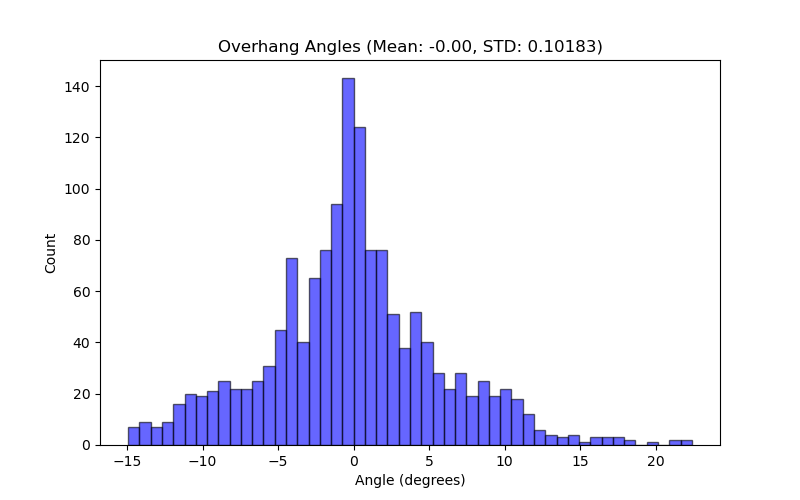

In [9]:
orient_mean = df['orientation'].mean()
orient_std = df['orientation'].std()

plt.figure(figsize=(8, 5))
plt.hist(df['orientation']*(180/np.pi), bins=50, density=False, alpha=0.6, color='blue', edgecolor='black')

plt.title(f'Overhang Angles (Mean: {orient_mean:.2f}, STD: {orient_std:.5f})')
plt.xlabel('Angle (degrees)')
plt.ylabel('Count')
plt.show()

We can calculate the 'vertical travel' of the overhangs and plot the distribution. 

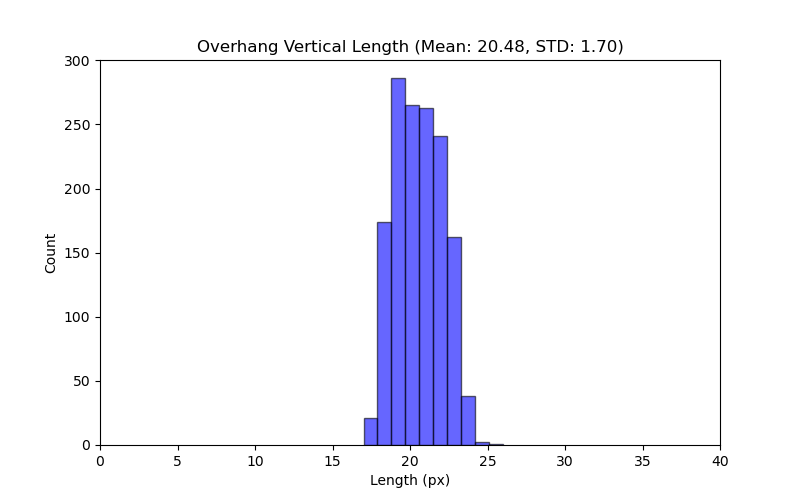

In [10]:
df['X-travel'] = df['bbox-3'] - df['bbox-1']
df['Y-travel'] = df['bbox-2'] - df['bbox-0']

# Calculate the standard deviations and means
yt_mean = df['Y-travel'].mean()
yt_std = df['Y-travel'].std()

plt.figure(figsize=(8, 5))
plt.hist(df['Y-travel'], bins=10, density=False, alpha=0.6, color='blue', edgecolor='black')

plt.title(f'Overhang Vertical Length (Mean: {yt_mean:.2f}, STD: {yt_std:.2f})')
plt.xlabel('Length (px)')
plt.xlim(0,40)
plt.ylabel('Count')
plt.show()

And plot the deviation in base position of the overhangs, a.k.a the height at which the overhangs start. This effectively measure the consistency of the cathode stacking height.

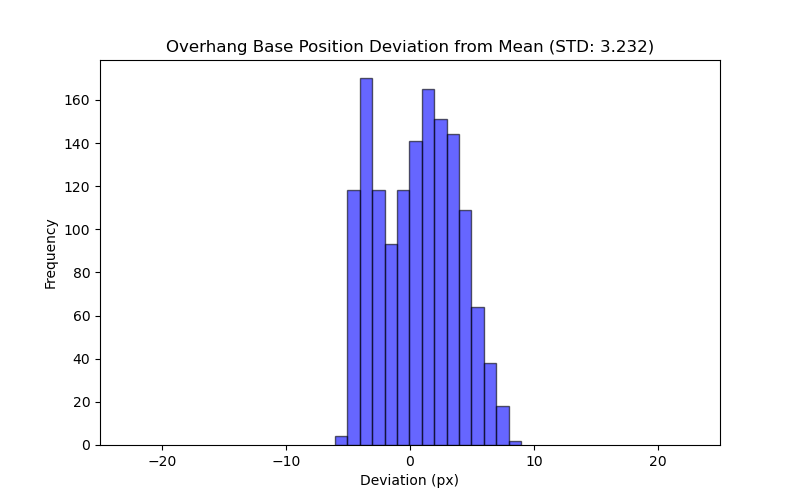

In [11]:
# Compute mean base height of overhang
df["mean_base"] = df["bbox-2"].mean()
# Deviation from mean height
df["electrode_height_deviation"] = df["bbox-2"] - df["mean_base"]

# Plot distribution
plt.figure(figsize=(8,5))
plt.hist(df["electrode_height_deviation"], bins=15, density=False, alpha=0.6, color='blue', edgecolor='black')

plt.xlabel("Deviation (px)")
plt.ylabel("Frequency")
plt.xlim(-25,25)
plt.title(f"Overhang Base Position Deviation from Mean (STD: {df['electrode_height_deviation'].std():.3f})")
plt.show()

### 4. Conclusion
This notebook may prove beneficial to battery quality control and manufacturing where it could be used to inform the assessment of overhang faults and stacking quality automatically from XCT tomograms of cylindrical cells.
If you have any questions or comments on this notebook please contact the authors.